In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

2025-11-14 06:04:44.857731: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-14 06:04:44.899566: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-14 06:04:44.899612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-14 06:04:44.901405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-14 06:04:44.909498: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-14 06:04:44.910219: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Used AI, see [1]

# load dataset from directory
dataset = tf.keras.utils.image_dataset_from_directory(
    "Project2",
    image_size=(128, 128),
    batch_size=2
)

# Inspect
for images, labels in dataset.take(1):
    print(images.shape, labels.shape)

Found 21322 files belonging to 2 classes.
(2, 128, 128, 3) (2,)


In [3]:
# sample one image from the dataset
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

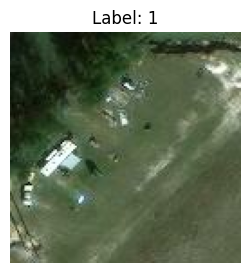

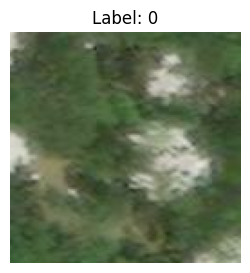

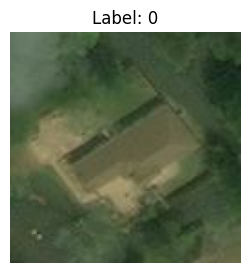

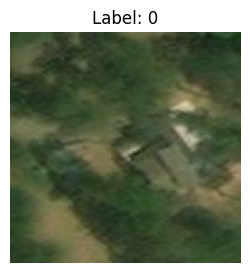

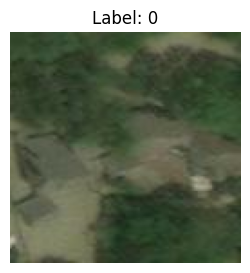

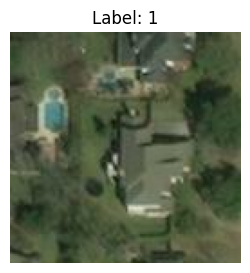

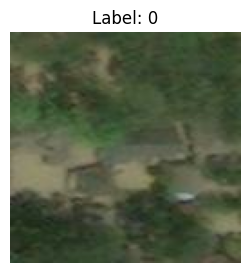

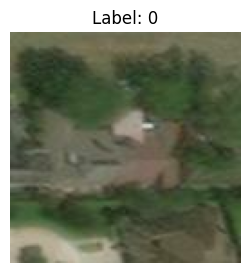

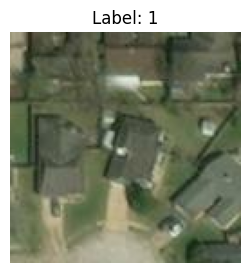

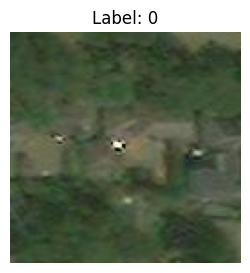

In [4]:
# Used AI, see [2]

for images, labels in dataset.take(10):
    plt.figure(figsize=(3, 3))
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(f"Label: {labels[0].numpy()}") # Display the label if available
    plt.axis("off")
    plt.show()

In [5]:
# load dataset as numpy
X = []
y = []
for images, labels in dataset:
    X.append(images.numpy())
    y.append(labels.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

# split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

In [6]:
# normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

## Part 2: Model design, training and evaluation

### Artificial Neural Network (ANN)

In [7]:

print("X_train shape:", X_train.shape)

# resize data due to memory issues
X_train_ann = tf.image.resize(X_train, (64, 64))
X_test_ann = tf.image.resize(X_test, (64, 64))

# reshape/flatten data
X_train_ann = X_train_ann.numpy()
X_test_ann = X_test_ann.numpy()

image_vector_size = 64*64*3
X_train_ann = X_train_ann.reshape(X_train_ann.shape[0], image_vector_size)
X_test_ann = X_test_ann.reshape(X_test_ann.shape[0], image_vector_size)

X_train shape: (14925, 128, 128, 3)


2025-11-14 06:04:57.715347: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2934374400 exceeds 10% of free system memory.


In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
# input layer
model.add(Dense(image_vector_size, activation='relu', input_shape=(image_vector_size,)))

# hidden layer
model.add(Dense(64, activation='relu'))

# output
model.add(Dense(1, activation='sigmoid'))

# train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(X_train_ann, y_train, validation_split=0.2, epochs=5, batch_size=128, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12288)             151007232 
                                                                 
 dense_1 (Dense)             (None, 64)                786496    
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 151793793 (579.05 MB)
Trainable params: 151793793 (579.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
94/94 - 83s - loss: 2.3171 - accuracy: 0.6143 - val_loss: 0.5609 - val_accuracy: 0.7313 - 83s/epoch - 880ms/step
Epoch 2/5
94/94 - 81s - loss: 0.6403 - accuracy: 0.6653 - val_loss: 0.6379 - val_accuracy: 0.6824 - 81s/epoch - 860ms/step
Epoch 3/5
94/94 - 80s - loss

In [9]:
test_loss, test_accuracy = model.evaluate(X_test_ann, y_test, verbose=0)
print(test_loss)
print(test_accuracy)

0.6526053547859192
0.6803188920021057


### Convolutional Neural Network (CNN)

In [10]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Flatten, Dense

print(X_train.shape)
print(y_train.shape)

model1 = Sequential()

# convolutional layer with 6 filters of size 5x5 + average pooling layer
model1.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(128, 128, 3)))
model1.add(AveragePooling2D(pool_size=(2, 2)))

# convolutional layer with 16 filters of size 5x5 + average pooling layer
model1.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model1.add(AveragePooling2D(pool_size=(2, 2)))

# flatten feature maps
model1.add(Flatten())

# dense/fully connected layer
model1.add(Dense(120, activation='relu'))

# dense/fully connected layer
model1.add(Dense(84, activation='relu'))

# output layer
model1.add(Dense(1, activation='sigmoid'))

# train
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()
model1.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=128, verbose=2)

(14925, 128, 128, 3)
(14925,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 62, 62, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 29, 29, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 13456)             0         
                                                                 
 dense_3 (Dense)        

2025-11-14 06:12:07.681386: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2347499520 exceeds 10% of free system memory.


94/94 - 37s - loss: 0.5655 - accuracy: 0.7265 - val_loss: 0.5684 - val_accuracy: 0.7300 - 37s/epoch - 396ms/step
Epoch 2/5
94/94 - 35s - loss: 0.4240 - accuracy: 0.8296 - val_loss: 0.4611 - val_accuracy: 0.8044 - 35s/epoch - 373ms/step
Epoch 3/5
94/94 - 35s - loss: 0.3590 - accuracy: 0.8586 - val_loss: 0.3726 - val_accuracy: 0.8616 - 35s/epoch - 370ms/step
Epoch 4/5
94/94 - 34s - loss: 0.2889 - accuracy: 0.8876 - val_loss: 0.2730 - val_accuracy: 0.8881 - 34s/epoch - 365ms/step
Epoch 5/5
94/94 - 33s - loss: 0.2445 - accuracy: 0.9018 - val_loss: 0.3042 - val_accuracy: 0.8683 - 33s/epoch - 354ms/step


In [11]:
test_loss1, test_accuracy1 = model1.evaluate(X_test, y_test, verbose=0)
print(test_loss1)
print(test_accuracy1)

0.29945847392082214
0.8754103779792786


In [12]:
model2 = Sequential()

# convolutional layer with 10 filters of size 8x8 + average pooling layer
model2.add(Conv2D(10, kernel_size=(8, 8), activation='relu', input_shape=(128, 128, 3)))
model2.add(AveragePooling2D(pool_size=(2, 2)))

# convolutional layer with 24 filters of size 6x6 + average pooling layer
model2.add(Conv2D(24, kernel_size=(6, 6), activation='relu'))
model2.add(AveragePooling2D(pool_size=(2, 2)))

# flatten feature maps
model2.add(Flatten())

# dense/fully connected layer
model2.add(Dense(120, activation='relu'))

# dense/fully connected layer
model2.add(Dense(84, activation='relu'))

# output layer
model2.add(Dense(1, activation='sigmoid'))

# train
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()
model2.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128, verbose=2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 121, 121, 10)      1930      
                                                                 
 average_pooling2d_2 (Avera  (None, 60, 60, 10)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 55, 55, 24)        8664      
                                                                 
 average_pooling2d_3 (Avera  (None, 27, 27, 24)        0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 17496)             0         
                                                                 
 dense_6 (Dense)             (None, 120)              

2025-11-14 06:15:10.749919: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2347499520 exceeds 10% of free system memory.


94/94 - 99s - loss: 0.6304 - accuracy: 0.6692 - val_loss: 0.5463 - val_accuracy: 0.7139 - 99s/epoch - 1s/step
Epoch 2/10
94/94 - 97s - loss: 0.4621 - accuracy: 0.8085 - val_loss: 0.4091 - val_accuracy: 0.8372 - 97s/epoch - 1s/step
Epoch 3/10
94/94 - 93s - loss: 0.3731 - accuracy: 0.8506 - val_loss: 0.3517 - val_accuracy: 0.8573 - 93s/epoch - 988ms/step
Epoch 4/10
94/94 - 89s - loss: 0.3177 - accuracy: 0.8746 - val_loss: 0.3038 - val_accuracy: 0.8771 - 89s/epoch - 951ms/step
Epoch 5/10
94/94 - 93s - loss: 0.2475 - accuracy: 0.9028 - val_loss: 0.3214 - val_accuracy: 0.8697 - 93s/epoch - 986ms/step
Epoch 6/10
94/94 - 93s - loss: 0.2207 - accuracy: 0.9152 - val_loss: 0.3037 - val_accuracy: 0.8717 - 93s/epoch - 990ms/step
Epoch 7/10
94/94 - 93s - loss: 0.1922 - accuracy: 0.9255 - val_loss: 0.2789 - val_accuracy: 0.8884 - 93s/epoch - 994ms/step
Epoch 8/10
94/94 - 95s - loss: 0.1736 - accuracy: 0.9329 - val_loss: 0.2708 - val_accuracy: 0.8988 - 95s/epoch - 1s/step
Epoch 9/10
94/94 - 95s - los

In [13]:
test_loss2, test_accuracy2 = model2.evaluate(X_test, y_test, verbose=0)
print(test_loss2)
print(test_accuracy2)

0.2850207984447479
0.8996404409408569


### LeNet from paper

In [14]:
# Used AI, see [4], [5]

from tensorflow.keras.layers import Conv2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model3 = Sequential()

# Block 1
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Classification head
model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(512, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))  # binary output

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()
model3.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=128, verbose=2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)      

2025-11-14 06:30:55.093861: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2347499520 exceeds 10% of free system memory.


94/94 - 79s - loss: 0.5183 - accuracy: 0.7496 - val_loss: 0.4179 - val_accuracy: 0.8147 - 79s/epoch - 837ms/step
Epoch 2/10
94/94 - 77s - loss: 0.2730 - accuracy: 0.8924 - val_loss: 0.3099 - val_accuracy: 0.8764 - 77s/epoch - 822ms/step
Epoch 3/10
94/94 - 78s - loss: 0.2210 - accuracy: 0.9109 - val_loss: 0.1756 - val_accuracy: 0.9280 - 78s/epoch - 828ms/step
Epoch 4/10
94/94 - 79s - loss: 0.1566 - accuracy: 0.9393 - val_loss: 0.1358 - val_accuracy: 0.9441 - 79s/epoch - 844ms/step
Epoch 5/10
94/94 - 79s - loss: 0.1239 - accuracy: 0.9518 - val_loss: 0.1820 - val_accuracy: 0.9310 - 79s/epoch - 843ms/step
Epoch 6/10
94/94 - 82s - loss: 0.1297 - accuracy: 0.9504 - val_loss: 0.1028 - val_accuracy: 0.9611 - 82s/epoch - 876ms/step
Epoch 7/10
94/94 - 80s - loss: 0.1023 - accuracy: 0.9611 - val_loss: 0.1107 - val_accuracy: 0.9581 - 80s/epoch - 848ms/step
Epoch 8/10
94/94 - 77s - loss: 0.0943 - accuracy: 0.9630 - val_loss: 0.1611 - val_accuracy: 0.9397 - 77s/epoch - 823ms/step
Epoch 9/10
94/94 - 

In [15]:
test_loss3, test_accuracy3 = model3.evaluate(X_test, y_test, verbose=0)
print(test_loss3)
print(test_accuracy3)

0.08398169279098511
0.9681100249290466


# Part 3: Inference Server

In [16]:
# save model3 (LeNet)
model3.save("damage.keras")